## ChatGPT Like

using TikToken

In [ ]:
!pip install tiktoken matplotlib -q
#!pip install matplotlib -q 

In [ ]:
import re
import matplotlib.pyplot as plt
import time
import os
import tiktoken
import torch
import torch.nn as nn
import numpy as np
from torch.nn import functional as F

Hyperparameters

In [65]:
batch_size = 128 #64 # how many independent sequences will we process in parallel?
block_size = 128 #256 # what is the maximum context length for predictions?
max_iters = 2
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.3
# ------------

#torch.manual_seed(1337)

In [4]:
torch.cuda.is_available()

True

## Set up

Read input + Tokenizer

In [5]:
import zipfile
with zipfile.ZipFile('afp-clean.txt.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [5]:
with open('frwiki.txt', 'r', encoding='utf-8') as f:
    text = f.read()
len(text)

234906617

In [6]:
with open('afp-clean.txt', 'r', encoding='utf-8') as f:
    text += f.read()
len(text)

4218119168

In [7]:
with open('input-fr-tiktoken.txt', 'r', encoding='utf-8') as f:
    text += f.read()
len(text)

4595939540

In [8]:
import re

def clean_text(text):
    # Remplace les caractères spéciaux et les chiffres par des espaces
    cleaned_text = re.sub('[^a-zA-Z]', ' ', text)
    # Convertit en minuscules
    cleaned_text = cleaned_text.lower()
    # Supprime les espaces en double
    cleaned_text = re.sub('\s+', ' ', cleaned_text)
    
    return cleaned_text

text = clean_text(text)

In [9]:
len(text)

4252582954

In [10]:
tokenizers = tiktoken.get_encoding("gpt2") #gpt2 cl100k_base
vocab_size = tokenizers.n_vocab
print("\nvocab size: ", vocab_size)


vocab size:  50257


Sampling
```
te = text[20000:20400]
len(tokenizers.encode(te))
```


In [11]:
data = torch.tensor(tokenizers.encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:12])

torch.Size([1291943032]) torch.int64
tensor([12172, 16111, 22357,   454, 12172, 16111,  1888,   568,   401,   660,
          390, 22357])


In [12]:
n = int(0.9*len(data)) # first 90% will be train, rest val
print(n)
train_data = data[:n]
val_data = data[n:]
#train_data[:block_size+1]

1162748728


Model + utilities

In [13]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [14]:
#backup_prefix = "saved-tiktoken-{}batch-{}block-".format(batch_size, block_size)
backup_prefix = "saved-tiktoken-64batch-128block-"
print(backup_prefix)

def get_last_backup(backup_prefix):
    matching_files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith(backup_prefix)]
    if (len(matching_files)==0):
        return ""
    return max(matching_files, key=os.path.getmtime)

def extract_iteration_count_from(file_name):
    match = re.search(r'\d+(?=-ite)', file_name)
    if match:
        return int(match.group())
    else:
        return 0


saved-tiktoken-64batch-128block-


In [15]:
def append_losses_to_file(filename, float_list):
    # open file in append mode
    with open(filename, 'a') as f:
        np.savetxt(f, float_list) #.numpy() 
    # close the file
    f.close()


## Instanciate model

Create Model

In [55]:
model = GPTLanguageModel()

Load weights from previous backup (if any)

In [56]:
last_backup_file = get_last_backup(backup_prefix)

In [57]:
if (len(last_backup_file)!=0):
    model.load_state_dict(torch.load(last_backup_file))
    model.eval()
    print("Weights loaded from", last_backup_file)

Weights loaded from saved-tiktoken-64batch-128block-5320-ite-x_xx


Prepare model

In [58]:
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

49.337425 M parameters


## Run Training

In [59]:
max_iters = 100

In [60]:
all_train_losses = []
all_val_losses = []
for iter in range(max_iters):
    start_time = time.time()

    # every once in a while evaluate the loss on train and val sets
    #if iter % eval_interval == 0 or iter == max_iters - 1:
    losses = estimate_loss()
    print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
    
    all_train_losses.append(losses['train'])
    all_val_losses.append(losses['val'])

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    print("Time : {:2f} seconds".format(time.time()-start_time))

step 0: train loss 3.4102, val loss 3.8977
Time : 18.832878 seconds
step 1: train loss 3.4404, val loss 3.9359
Time : 18.835680 seconds
step 2: train loss 3.5057, val loss 3.9718
Time : 18.833261 seconds
step 3: train loss 3.4610, val loss 3.9371
Time : 18.831726 seconds
step 4: train loss 3.4620, val loss 3.9255
Time : 18.815757 seconds
step 5: train loss 3.4728, val loss 3.9653
Time : 18.837496 seconds
step 6: train loss 3.4775, val loss 3.9811
Time : 18.815846 seconds
step 7: train loss 3.4567, val loss 3.9601
Time : 18.818722 seconds
step 8: train loss 3.4566, val loss 3.9260
Time : 18.829642 seconds
step 9: train loss 3.4596, val loss 3.9252
Time : 18.798090 seconds
step 10: train loss 3.4607, val loss 3.9397
Time : 18.805257 seconds
step 11: train loss 3.4600, val loss 3.9609
Time : 18.843353 seconds
step 12: train loss 3.4597, val loss 3.9546
Time : 18.834365 seconds
step 13: train loss 3.4609, val loss 3.9500
Time : 18.837474 seconds
step 14: train loss 3.4474, val loss 3.9498


Create samples

In [61]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)

print(tokenizers.decode(m.generate(context, max_new_tokens=250)[0].tolist()))
#open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))


! inauguration elle a d nonc son r sident quand elle regardait la pr sidente d importe une d n galaise tre confront e de d c dans laquelle la ligue desoiseaux corim tres a b servi lanc liste des silselabires l anvo en cas deLG balad edoint d autorast le chef de f d ration de la ville tre attribu d accord sur le ierge du raf stationn et qu il s agira sur le m me cap re terrer des forces officielles et une campagne qui oivent sa part indiquer l inde en garantiment depuis dans lequel et marin david serp le conseil de s curit fiat toNeg du ariel pattel trad aux etats unis ont pour le dossier appel d mocrates et qu il devait intervenir vers le stade mondial du congr s en goran l onu le pentabel am ricain pld dames atlerin par colombie deux bastions dont marquent les talibans tras la bande de geter


In [62]:
context = torch.tensor([tokenizers.encode("Sous un soleil, ")], dtype=torch.long, device=device)

print(tokenizers.decode(m.generate(context, max_new_tokens=250)[0].tolist()))
#open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))


Sous un soleil, auss dodi bertona pays bas dont la r gion au bout de la route serbe avit e d sicholes pied suivi res arm es rouches remplissant son tour g n ral fra renversement de la jeunisson funer e par une garde frest e ravitaillement un pilote de points en e pieds le santa dengou apr s l gislene gl lamuaili uupr s du minist re u de medental le rappelant que ces vols de l achir les quilibreurs assistance sur la premi re r gn e d ex fense atlantique qu ils devraient tre sign pour ailleurs les pays habitu s le couple est mitig par les victoires dans un d fiose de sum s soul dans un rebond tout co nveau groupe de r dactionn oncom a pr cis que nous avons fait de telles ch c t de la r alit qu il m dit le cardinal peliak impression n y quo m absorption de travailleurs il rejoint c


Save results

In [63]:
last_iteration = extract_iteration_count_from(last_backup_file)
current_iteration = last_iteration + max_iters
current_save = "{}{}-ite-x_xx".format(backup_prefix, current_iteration)
print("Save in:",current_save)

Save in: saved-tiktoken-64batch-128block-5420-ite-x_xx


In [64]:
torch.save(model.state_dict(), current_save)

append_losses_to_file("saved-tiktoken-train-losses.txt", all_train_losses)
append_losses_to_file("saved-tiktoken-val-losses.txt", all_val_losses)

## Graphs

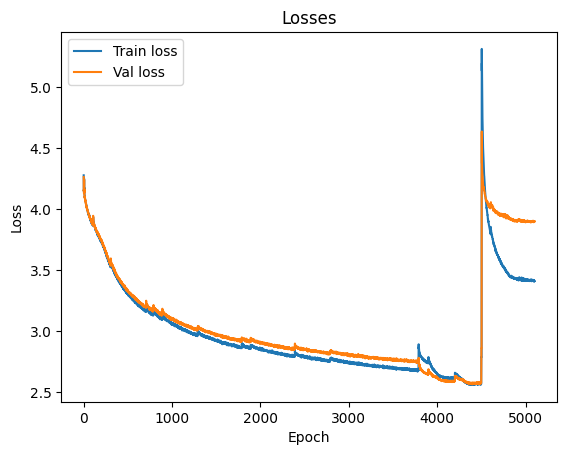

In [52]:
# load array from file and convert to PyTorch tensor
train_losses = np.loadtxt('saved-tiktoken-train-losses.txt')
val_losses = np.loadtxt('saved-tiktoken-val-losses.txt')
#my_tensor = torch.from_numpy(my_array)


def plot_losses(losses1, losses2):
    # create a new figure
    plt.figure()

    # plot the first series of losses
    plt.plot(losses1, label='Train loss')

    # plot the second series of losses
    plt.plot(losses2, label='Val loss')

    # add labels and title to the plot
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Losses')

    # add a legend to the plot
    plt.legend()

    # display the plot
    plt.show()

plot_losses(train_losses, val_losses)

## Clean-up

In [66]:
del m
del model
del optimizer

torch.cuda.empty_cache()

.